Basic Seq2Seq Bi-GRU OCR engine for digits trained using CTC loss with a Best Path decoder. It was coded to serve as a starting point for more serious projects; also for me to have a backup.

More details available here: https://codingvision.net/ai/pytorch-crnn-seq2seq-digits-recognition-ctc

In [12]:
#@title Dataset Generator
#@markdown Generates **random sequences** of equal length using digits from the **EMNIST** dataset while also performing basic augmentation.
#@markdown Saves results in **dataset/** directory: *data_\<seq_len\>_\<num_seq\>.npy* (images) and *labels_\<seq_len\>_\<num_seq\>.npy* (labels/GTs).
import torch
from torchvision import datasets, transforms
import numpy as np
import os

digits_per_sequence = 5
n_of_sequences = 10000 
output_path = './dataset/'

emnist_dataset = datasets.EMNIST('./EMNIST', split="digits", train=True, download=True)

dataset_sequences = []
dataset_labels = []

for i in range(n_of_sequences):
  random_indices = np.random.randint(len(emnist_dataset.data), size=(digits_per_sequence,))
  
  random_digits_images = emnist_dataset.data[random_indices]

  transformed_random_digits_images = []
  
  for img in random_digits_images:
    _temp_img = transforms.ToPILImage()(img)

    # fix EMNIST's transposed images
    _temp_img = transforms.functional.rotate(_temp_img, -90, fill=(0,))
    _temp_img = transforms.functional.hflip(_temp_img)

    # basic augmentation on each EMNIST digit
    _temp_img = transforms.RandomAffine(degrees=10, translate=(0.2, 0.15), scale=(0.8, 1.1))(_temp_img)
    _temp_img = transforms.ToTensor()(_temp_img).numpy()

    transformed_random_digits_images.append(_temp_img)

  random_digits_images = np.array(transformed_random_digits_images)
  
  random_digits_labels = emnist_dataset.targets[random_indices]

  random_sequence = np.hstack(random_digits_images.reshape(digits_per_sequence, 28, 28))
  random_labels = np.hstack(random_digits_labels.reshape(digits_per_sequence, 1))

  dataset_sequences.append(random_sequence / 255)
  dataset_labels.append(random_labels)

if not os.path.exists(output_path): 
  os.makedirs(output_path)

dataset_data = np.array(dataset_sequences)
dataset_labels = np.array(dataset_labels)

data_path = output_path + "data_" + str(digits_per_sequence) + "_" + str(n_of_sequences) + ".npy"
np.save(data_path, dataset_data)

label_path = output_path + "labels_" + str(digits_per_sequence) + "_" + str(n_of_sequences) + ".npy"
np.save(label_path, dataset_labels)



In [13]:
#@title Dataset Loader
#@markdown Loads the generated dataset and creates 2 **DataLoader** instances (for training and testing)

import torch.utils.data as data_utils
import numpy as np
import torch

data_path = './dataset/data_5_10000.npy'
labels_path = './dataset/labels_5_10000.npy'

data = np.load(data_path)
data = torch.Tensor(data)
labels = torch.IntTensor(np.load(labels_path).astype(int))

seq_dataset = data_utils.TensorDataset(data, labels)
train_set, test_set = torch.utils.data.random_split(seq_dataset, [int(len(seq_dataset)*0.8), int(len(seq_dataset)*0.2)])

train_loader = torch.utils.data.DataLoader(train_set, batch_size=32*2, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=True)

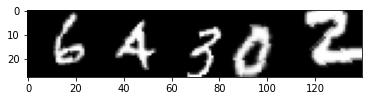

tensor([6, 4, 3, 0, 2], dtype=torch.int32)


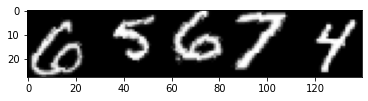

tensor([6, 5, 6, 7, 4], dtype=torch.int32)


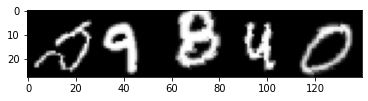

tensor([2, 9, 8, 4, 0], dtype=torch.int32)


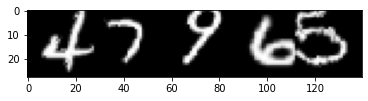

tensor([4, 7, 9, 6, 5], dtype=torch.int32)


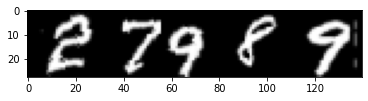

tensor([2, 7, 9, 8, 9], dtype=torch.int32)


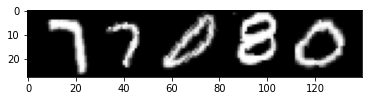

tensor([7, 7, 0, 8, 0], dtype=torch.int32)


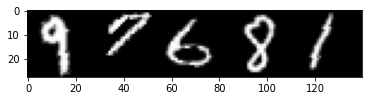

tensor([9, 7, 6, 8, 1], dtype=torch.int32)


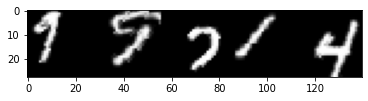

tensor([9, 9, 7, 1, 4], dtype=torch.int32)


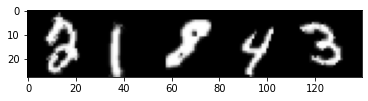

tensor([2, 1, 8, 4, 3], dtype=torch.int32)


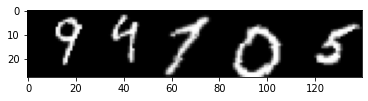

tensor([9, 4, 7, 0, 5], dtype=torch.int32)


In [14]:
#@title Debug: Show Dataset Images
import matplotlib.pyplot as plt

number_of_printed_imgs = 10

for batch_id, (x_test, y_test) in enumerate(train_loader):
  for j in range(len(x_test)):
    plt.imshow(x_test[j], cmap='gray')
    plt.show()

    print(y_test[j])
    number_of_printed_imgs -= 1

    if number_of_printed_imgs <= 0:
      break

  if number_of_printed_imgs <= 0:
      break
  


In [28]:
#@title CRNN Model
#@markdown Applies a LeNet-5 based features extraction using strided convolutions instead of maxpooling. 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.nn.init as init

class CRNN(nn.Module):

    def __init__(self):
        super(CRNN, self).__init__()

        self.num_classes = 10 + 1
        self.image_H = 28

        self.conv1 = nn.Conv2d(1, 32, kernel_size=(3,3))
        self.in1 = nn.InstanceNorm2d(32)

        self.conv2 = nn.Conv2d(32, 32, kernel_size=(3,3))
        self.in2 = nn.InstanceNorm2d(32)

        self.conv3 = nn.Conv2d(32, 32, kernel_size=(3,3), stride=2)
        self.in3 = nn.InstanceNorm2d(32)

        self.conv4 = nn.Conv2d(32, 64, kernel_size=(3,3))
        self.in4 = nn.InstanceNorm2d(64)

        self.conv5 = nn.Conv2d(64, 64, kernel_size=(3,3))
        self.in5 = nn.InstanceNorm2d(64)

        self.conv6 = nn.Conv2d(64, 64, kernel_size=(3,3), stride=2)
        self.in6 = nn.InstanceNorm2d(64)

        self.postconv_height = 3
        self.postconv_width = 31

        self.gru_input_size = self.postconv_height * 64
        self.gru_hidden_size = 128 
        self.gru_num_layers = 2
        self.gru_h = None
        self.gru_cell = None

        self.gru = nn.GRU(self.gru_input_size, self.gru_hidden_size, self.gru_num_layers, batch_first = True, bidirectional = True)

        self.fc = nn.Linear(self.gru_hidden_size * 2, self.num_classes)

    def forward(self, x):
        batch_size = x.shape[0]

        out = self.conv1(x) 
        out = F.leaky_relu(out)
        out = self.in1(out)

        out = self.conv2(out) 
        out = F.leaky_relu(out)
        out = self.in2(out)

        out = self.conv3(out)
        out = F.leaky_relu(out)
        out = self.in3(out)

        out = self.conv4(out)
        out = F.leaky_relu(out)
        out = self.in4(out)

        out = self.conv5(out)
        out = F.leaky_relu(out)
        out = self.in5(out)

        out = self.conv6(out)
        out = F.leaky_relu(out)
        out = self.in6(out)

        out = out.permute(0, 3, 2, 1) 
        out = out.reshape(batch_size, -1, self.gru_input_size)

        out, gru_h = self.gru(out, self.gru_h)
        self.gru_h = gru_h.detach()
        out = torch.stack([F.log_softmax(self.fc(out[i])) for i in range(out.shape[0])])
        
        return out

    def reset_hidden(self, batch_size):
        h = torch.zeros(self.gru_num_layers * 2, batch_size, self.gru_hidden_size)
        self.gru_h = Variable(h)

    
    
crnn = CRNN().to(device)
criterion = nn.CTCLoss(blank=10, reduction='mean', zero_infinity=True)
optimizer = torch.optim.Adam(crnn.parameters(), lr=0.001) 

BLANK_LABEL = 10
MAX_EPOCHS = 100



In [29]:
#@title Training & Testing


from itertools import groupby

def test():
  correct = 0
  total = 0
  num_batches = 0

  total_loss = 0
  for batch_id, (x_test, y_test) in enumerate(test_loader):
    batch_size = x_test.shape[0]
    crnn.reset_hidden(batch_size)

    x_test = x_test.view(x_test.shape[0], 1, x_test.shape[1], x_test.shape[2])

    y_pred = crnn(x_test)  
    y_pred = y_pred.permute(1, 0, 2)

    input_lengths = torch.IntTensor(batch_size).fill_(crnn.postconv_width)
    target_lengths = torch.IntTensor([len(t) for t in y_test])

    loss = criterion(y_pred, y_test, input_lengths, target_lengths)

    total_loss += loss.detach().numpy()
    
    _, max_index = torch.max(y_pred, dim=2)

    for i in range(batch_size):
      raw_prediction = list(max_index[:, i].numpy())
      
      prediction = torch.IntTensor([c for c, _ in groupby(raw_prediction) if c != BLANK_LABEL])

      if len(prediction) == len(y_test[i]) and torch.all(prediction.eq(y_test[i])):
        correct += 1
      total += 1
    num_batches += 1

  ratio = correct / total
  print('TEST correct: ', correct, '/', total, ' P:', ratio)

  return total_loss / num_batches

def train():

  correct = 0
  total = 0

  total_loss = 0
  num_batches = 0

  for batch_id, (x_train, y_train) in enumerate(train_loader):
    
    batch_size = x_train.shape[0]
    crnn.reset_hidden(batch_size)

    x_train = x_train.view(x_train.shape[0], 1, x_train.shape[1], x_train.shape[2])
    

    optimizer.zero_grad()  
    
    y_pred = crnn(x_train)
    y_pred = y_pred.permute(1, 0, 2)
    
    input_lengths = torch.IntTensor(batch_size).fill_(crnn.postconv_width)
    target_lengths = torch.IntTensor([len(t) for t in y_train])

    

    loss = criterion(y_pred, y_train, input_lengths, target_lengths)
    total_loss += loss.detach().numpy()

    loss.backward()
    optimizer.step()

    _, max_index = torch.max(y_pred, dim=2)
    
    for i in range(batch_size):
      raw_prediction = list(max_index[:, i].numpy())
      
      prediction = torch.IntTensor([c for c, _ in groupby(raw_prediction) if c != BLANK_LABEL])

      if len(prediction) == len(y_train[i]) and torch.all(prediction.eq(y_train[i])):
        correct += 1
      total += 1

    num_batches += 1

  ratio = correct / total
  print('TRAIN correct: ', correct, '/', total, ' P:', ratio)

  return total_loss / num_batches

list_training_loss = []
list_testing_loss = []

for epoch in range(MAX_EPOCHS):
  
  training_loss = train()
  testing_loss = test()

  list_training_loss.append(training_loss)
  list_testing_loss.append(testing_loss)
  
  if epoch == 5:
    print('training loss', list_training_loss)
    print('testing loss', list_testing_loss)
    break

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:80: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


TRAIN correct:  750 / 8000  P: 0.09375
TEST correct:  1106 / 2000  P: 0.553
TRAIN correct:  5856 / 8000  P: 0.732
TEST correct:  1611 / 2000  P: 0.8055
TRAIN correct:  6865 / 8000  P: 0.858125
TEST correct:  1702 / 2000  P: 0.851
TRAIN correct:  7229 / 8000  P: 0.903625
TEST correct:  1768 / 2000  P: 0.884
TRAIN correct:  7417 / 8000  P: 0.927125
TEST correct:  1735 / 2000  P: 0.8675
TRAIN correct:  7567 / 8000  P: 0.945875
TEST correct:  1776 / 2000  P: 0.888
training loss [2.0841852526664733, 0.23532865685224533, 0.1125646015405655, 0.07534531292319298, 0.05514940223842859, 0.040529083728790286]
testing loss [0.42983535713516174, 0.157542273686151, 0.11668043021782068, 0.09346830770061934, 0.10840072430390865, 0.0854211449205468]
